In [1]:
%matplotlib inline

from __future__ import print_function, division

# Author: Xiang Wang

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable, grad
from torch.utils.data import DataLoader


import torchvision
from torchvision import datasets, models, transforms, models

from tensorboardX import SummaryWriter

import numpy as np
import time
import os
import copy
import pickle

import matplotlib.pyplot as plt

plt.ion()   # interactive mode

## 一、数据加载与处理

In [2]:
# Data ToTensor and normalization for training

data_transforms = transforms.Compose([transforms.ToTensor(), 
                                      transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                                     ])


In [3]:
# load dataset

# 使用datasets.CIFAR10加载图片
image_datasets = datasets.CIFAR10('D:/1.Program/1.DataAnalysisPrograme/DeepLearning/Pytroch/PlayGround/cifar10/', train=True, 
                                  download=True, transform=data_transforms)

# 得到可batch的数据格式
data_loaders = DataLoader(image_datasets, batch_size=64, shuffle=True, num_workers=0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified


In [4]:
train_data = data_loaders

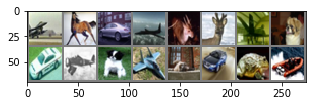

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.detach().numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_data))
inputs = inputs[0:16]
# Make a grid from batc
out = torchvision.utils.make_grid(inputs)
plt.figure(figsize=(5,5))

imshow(out)

## 二、创建模型

In [6]:
def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

In [7]:
class DCGAN_D(nn.Module):
    def __init__(self):
        super(DCGAN_D, self).__init__()
        
        self.conv = nn.Sequential(

            nn.Conv2d(3, 64,  kernel_size=4,  stride=2, padding=1),
            nn.InstanceNorm2d(64, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128,  kernel_size=4,  stride=2, padding=1),
            nn.InstanceNorm2d(128, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256,  kernel_size=4,  stride=2, padding=1),
            nn.InstanceNorm2d(256, affine=True),
            nn.LeakyReLU(0.2,inplace=True),

        )
        
        self.fc = nn.Sequential(
            nn.Conv2d(256, 1,  kernel_size=4,  stride=1, padding=0),
        )
        initialize_weights(self)

        
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)

        x = x.view(x.shape[0], -1)
        return x

In [8]:
class DCGAN_G(nn.Module):
    def __init__(self, noise_dim=100):
        super(DCGAN_G, self).__init__()
        
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=100, out_channels=256, kernel_size=4, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        initialize_weights(self)
        
    def forward(self, x):
        x = x.view(x.shape[0], 100, 1, 1) 
        x = self.conv(x)

        return x

In [26]:
G_net = DCGAN_G()
D_net = DCGAN_D()

### 三、设置必要的参数

In [33]:
G_net = G_net.to(device)
D_net = D_net.to(device)

In [34]:
# 使用 adam 来进行训练
def get_optimizer(net, lr=1e-4):
    optimizer = torch.optim.Adam(net.parameters(), lr, betas=(0.5, 0.9))
    return optimizer

optimizer_D = get_optimizer(D_net)
optimizer_G = get_optimizer(G_net)

In [35]:
# 损失函数构建

# gradient_penalty的构建
def gradient_penalty(D_net, real_images, fake_images, device=device):

    # 随机生成batch_size个随机值（0～1），并将其广播成和数据一样的格式
    # 其目前是为了得到介于真实数据和生成数据之间的点
    epsilon = torch.rand(batch_size, 1, device=device, requires_grad=True)
    epsilon_exp = epsilon.expand(batch_size, real_images.nelement()/batch_size).contiguous().view(real_images.size())
    epsilon_exp = epsilon_exp.to(device)
    
    # 生成真实数据和生成数据之间的点
    inter_images = epsilon_exp * real_images.data + (1 - epsilon_exp) * fake_images.data
    inter_images = Variable(inter_images, requires_grad=True)
    
    
    # 用判别模型来判断interpolates的真假
    inter_loss = D_net(inter_images)
    
    # 得到梯度
    gradients = grad(outputs=inter_loss, inputs=inter_images, grad_outputs=torch.ones(inter_loss.size()).to(device), 
                                    create_graph=True, retain_graph=True, only_inputs=True)[0]
    
    gradients = gradients.view(gradients.size(0), -1)
    
    # 得到WGAN-GP中添加的gradient_penalty正则项
    return ((gradients.norm(2, dim=1) - 1) ** 2).mean()


# W损失的定义
# 返回带正则项的损失函数（用于反向传播）；对于真实图片的判别；对于生成图片的判别
def wasserstein_loss(D_net, real_images, fake_images, device=device, gp_lambda=10):
    
    return ((D_net(fake_images) - D_net(real_images)).mean() + gradient_penalty(D_net, real_images, fake_images) * gp_lambda),\
            (D_net(real_images)).mean(), (D_net(fake_images)).mean()


In [36]:
batch_size = 64
NOISE_DIM =100

### 四、训练模型

In [41]:
def train_model(D_net, G_net, D_optimizer, G_optimizer, show_every=250, noise_size=100, 
                num_epochs=10,  n_critic = 5, lambda_=10):
    since = time.time()
   
    writer = SummaryWriter('log')
    
    iter_count = 0
    
    # z_sample = (torch.rand(64, noise_size) - 0.5) / 0.5  # 生成（-1 ~ 1）的噪声
    z_sample = Variable(torch.randn(64, NOISE_DIM))
    z_sample = z_sample.to(device)

    for epoch in range(num_epochs):
        print('epoch: ', epoch)
        # 因为每次epoch结束就让其生成图片，所以在开始时先.train（）一下
        G_net.train()

        for i,(real_images, label) in  enumerate(train_data):
            # 因为最后一个batch可能数量不符，所以舍弃掉
            if i == train_data.dataset.__len__() // batch_size:
                break


   #******** 1. 训练判别网络 *****************************#
            
            D_optimizer.zero_grad()
        
            # 首先得到真实数据
            real_images = real_images.cuda()# 真实数据  
            
            D_real_loss = -torch.mean(D_net(real_images))
            
            # 用生成器生成数据
            sample_noise = torch.rand((batch_size, noise_size))
            sample_noise = sample_noise.cuda()
            fake_images = G_net(sample_noise) # 生成的假的数据
            
            # 计算损失，进行反向更新，更新判别器
            D_loss, D_real_loss, D_fake_loss = wasserstein_loss(D_net, real_images, fake_images)
            W_loss = D_real_loss - D_fake_loss
            
            D_loss.backward(retain_graph=True)
            D_optimizer.step()

    #******** 2. 训练生成网络 ***************************#
            if ((i+1) % n_critic) == 0:
                G_optimizer.zero_grad()

                fake_images = G_net(sample_noise) # 生成的假的数据
                
                # 用生成的数据得到判别网络的得分
                G_loss = -torch.mean(D_net(fake_images))
            
                G_loss.backward()
                G_optimizer.step()

                iter_count += 1
                

                        
                if (iter_count < 2 or iter_count % show_every == 0):
            
                    time_elapsed = time.time() - since
                    print('Iter: {}, real: {:.4}, fake:{:.4}'.format(iter_count, (D_real_loss).item(), D_fake_loss.item()))
                    print('Iter: {}, D: {:.4}, G:{:.4}, W:{:.4}'.format(iter_count, D_loss.item(), G_loss.item(), W_loss.item()))
                    
                    print('Time: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

                    
                    
        with torch.no_grad():
            out = torchvision.utils.make_grid(G_net(z_sample).cpu()[0:16])
            plt.figure(figsize=(5,5))
            imshow(out)

            plt.show()
        
        # 使用 tensorboard 
        writer.add_scalar('W_Loss', W_loss.item(), iter_count)
        writer.add_scalar('G_loss', G_loss.item(), iter_count) 
        
    return D_net, G_net

In [43]:
D_net, G_net = train_model(D_net, G_net, optimizer_D, optimizer_G)

训练后的结果：
![WGAN_GP_Picture](Picture/WGAN_GP1.png)

### 五、保存模型

In [ ]:
# 模型保存
torch.save(D_net, 'D_net.pkl')
torch.save(G_net, 'G_net.pkl')

In [ ]:
# 模型加载
D_net = torch.load('D_net.pkl')    
G_net = torch.load('G_net.pkl')    